In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sns.set(style='whitegrid')
sys.path.append('..')

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=RuntimeWarning)

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression, LogisticRegression
from load_data import *

/home/jules/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load the data

In [2]:
df = load_dataset('../data/DataTrain.txt')
df = df.set_index('engine_id')

df = df[['cycle', 's11', 's4', 's12', 's7', 's15', 's21', 's20', 's17', 's2', 's3', 's13', 's8']]

df_test  = df[df.index > 90]
df_train = df[df.index <= 90]

### Get the remaining time for each engine

In [3]:
def get_ruls(dataframe):
    """
    Get the ruls of the engines
    """
    # Try to drop max cycle to prevent an error
    dataframe = dataframe.drop('max_cycle', 1, errors='ignore')
    
    # The max cycle of each engine
    max_cycle = dataframe.groupby('engine_id').agg({'cycle': 'max'}).rename({'cycle': 'max_cycle'}, axis=1)
    
    # Add the max cycle to the dataframe
    dataframe = dataframe.join(max_cycle, on='engine_id', )
    
    # Ruls are max cycle minus current cycle (plus 1)
    ruls = (dataframe['max_cycle'] - dataframe['cycle'] + 1).values
    
    return ruls

df_train.loc[:, 'rul'] = get_ruls(df_train)
df_test.loc[:, 'rul']  = get_ruls(df_test)

df_train[['cycle', 'rul']].tail()

/home/jules/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jules/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


cycle  rul
engine_id            
90           150    5
90           151    4
90           152    3
90           153    2
90           154    1

### Plot the timeseries of the engines

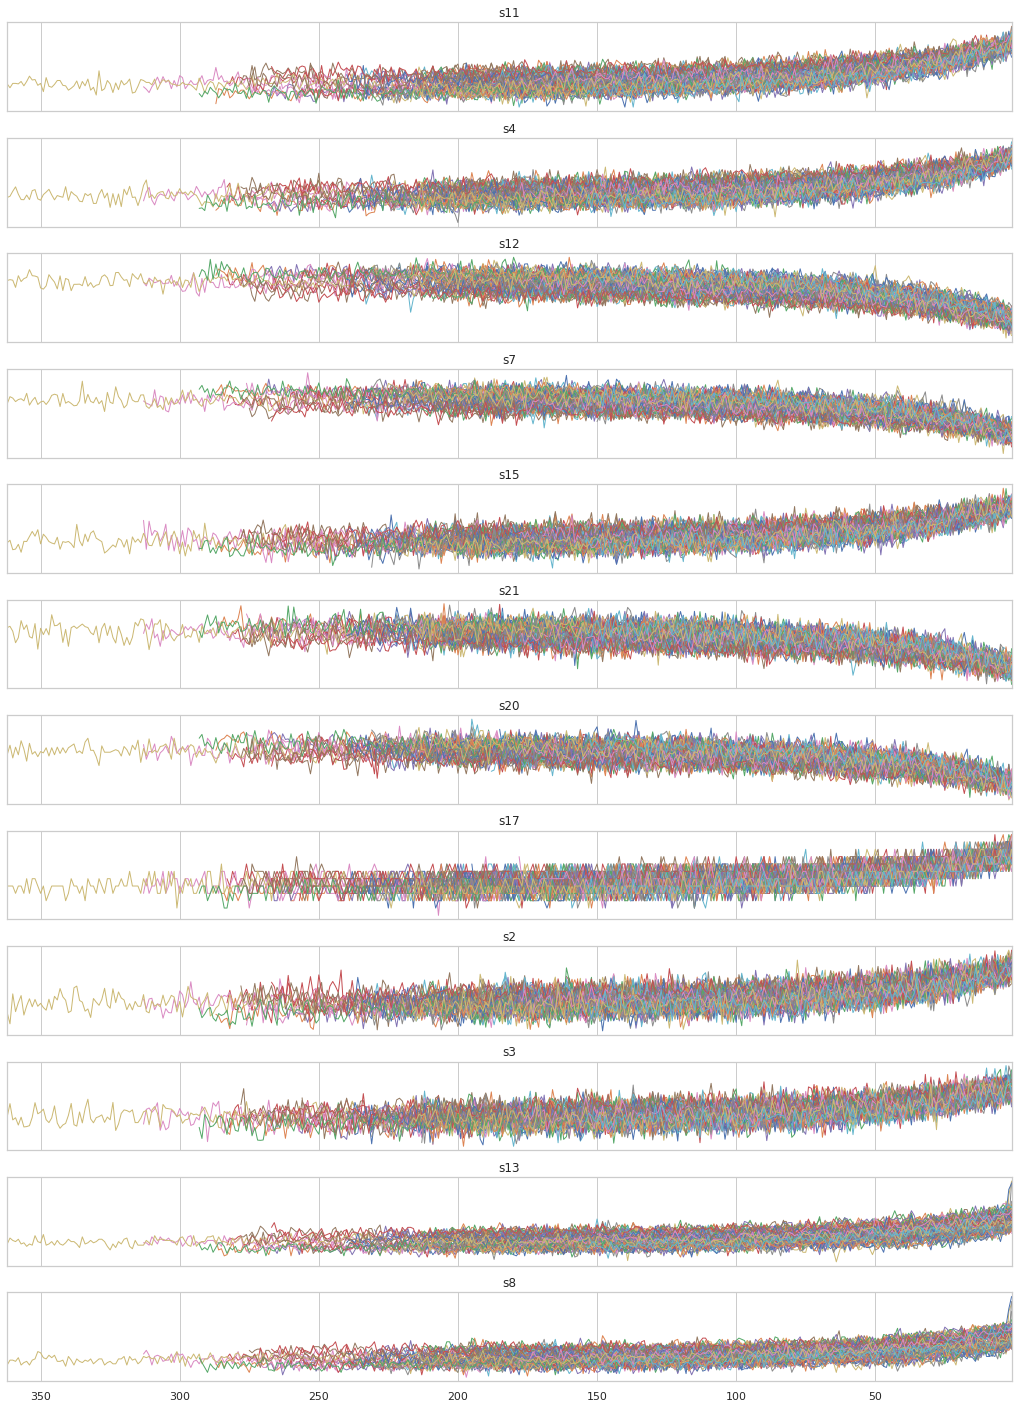

In [4]:
def plot_timeseries(dataframe):
    ts = dataframe.copy()
    
    max_rul = ts['rul'].max()
    
    ts.drop(labels=['cycle'], axis=1, inplace=True)

    cols = ts.columns
    fig, axes = plt.subplots(len(cols)-1, 1, figsize=(18,25), sharex=True)

    for col, ax in zip(cols, axes):
        if col == 'rul':
            continue

        ax.set_title(col, fontdict={'fontsize': 12})
        ax.set_xlim(max_rul, 1)
        ax.get_yaxis().set_visible(False)

        for engine_id in ts.index.unique():
            time = ts.loc[engine_id, 'rul']
            ax.plot(time, ts.loc[engine_id,col], label=col, linewidth=1)

    plt.subplots_adjust(hspace=0.3)
    
plot_timeseries(df_train)

### Normalize the sensors

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
df_train_norm = df_train.copy()
df_test_norm  = df_test.copy()

scaler = StandardScaler()

df_train_norm.iloc[:, 1:-1] = scaler.fit_transform(df_train.iloc[:, 1:-1])
df_test_norm.iloc[:, 1:-1]  = scaler.transform(df_test.iloc[:, 1:-1])

df_train_norm.head()

cycle       s11        s4       s12        s7       s15       s21  \
engine_id                                                                      
1              1 -0.272120 -0.931357  0.338324  1.123013 -0.608836  1.197738   
1              2 -0.197296 -0.649048  1.175963  0.436262 -0.281083  1.240099   
1              3 -1.020359 -0.531234  1.365107  1.010431 -0.654136  0.508906   
1              4 -1.544127 -0.790202  1.959560  1.224337 -1.975809  0.782413   
1              5 -0.982947 -0.306721  1.054370  0.717717 -0.345035  1.063287   

                s20       s17        s2        s3       s13        s8  rul  
engine_id                                                                   
1          1.352743 -0.784567 -1.727957 -0.139234 -1.057496 -0.522026  192  
1          1.020928 -0.784567 -1.068131  0.206983 -0.368732 -0.801477  191  
1          0.744415 -2.074286 -0.668236 -0.418494 -0.919743 -0.242574  190  
1          0.357297 -0.784567 -0.668236 -1.267706 -0.230979  0.176603  189  
1          0.467902 -0.139708 -0.628246 -1.257907 -0.781991 -0.522026  188

### Linear regression on the slopes
The engine to use for testing

In [7]:
ENGINE_ID = 87

#### The sensor columns

In [8]:
sensor_cols = df_train.columns[1:-1].tolist()
sensor_cols

['s11', 's4', 's12', 's7', 's15', 's21', 's20', 's17', 's2', 's3', 's13', 's8']

#### The X data is the RUL

In [9]:
X = df_train_norm.loc[ENGINE_ID, 'rul'].values
X = X.reshape(-1, 1)
X[:5,:]

array([[178],
       [177],
       [176],
       [175],
       [174]], dtype=int64)

#### The Y data are the sensor values

In [10]:
y = df_train_norm.loc[ENGINE_ID, sensor_cols].values
y[:5, :5]

array([[-0.68365158, -0.5278996 ,  0.89224642,  1.04420571, -0.09988549],
       [-0.38435594,  0.30346706,  0.54097866,  0.61639348,  0.02535375],
       [-0.72106354, -1.10585504,  0.89224642,  1.01043106, -0.46760922],
       [-0.98294723, -1.27701876,  0.75714343, -0.50942817,  0.09197036],
       [-0.72106354, -0.37563058,  0.97330821, -0.12664881, -0.61150111]])

#### Fit the linear models

In [11]:
linear_model = LinearRegression()

In [12]:
linear_model.fit(X, y);

In [13]:
linear_model.coef_

array([[-0.01330677],
       [-0.01369452],
       [ 0.01489006],
       [ 0.0133061 ],
       [-0.01237868],
       [ 0.01112286],
       [ 0.01251427],
       [-0.01093805],
       [-0.01150168],
       [-0.01164959],
       [-0.01665909],
       [-0.0158528 ]])

#### Run the prediction on the sensor data

In [14]:
y_hat = linear_model.predict(X)
y_hat[:5, :5]

array([[-0.9146518 , -0.99791394,  1.08266606,  0.89768989, -0.87647693],
       [-0.90134503, -0.98421941,  1.067776  ,  0.88438379, -0.86409825],
       [-0.88803826, -0.97052489,  1.05288594,  0.8710777 , -0.85171958],
       [-0.8747315 , -0.95683037,  1.03799587,  0.8577716 , -0.8393409 ],
       [-0.86142473, -0.94313585,  1.02310581,  0.8444655 , -0.82696223]])

#### Plot the sensor data and fitted trends

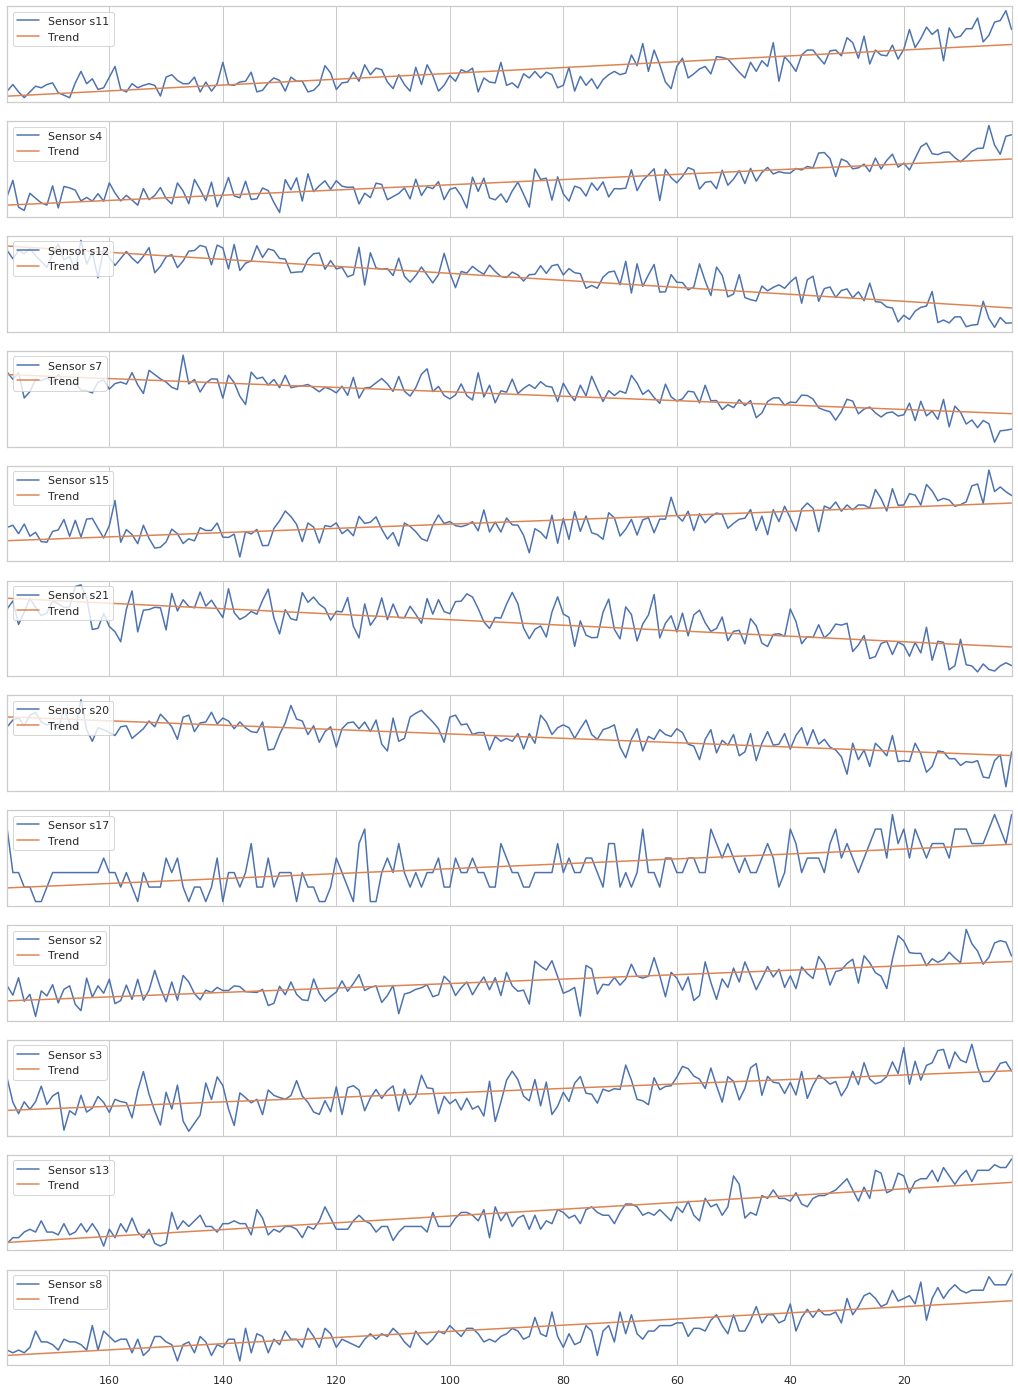

In [15]:
# plotting 
time    = X.flatten()
sensors = y

fig, axes = plt.subplots(len(sensor_cols), 1, figsize=(18, 25), sharex=True)

for col, ax in zip(range(len(sensor_cols)), axes):
    ax.plot()
    
    ax.plot(time, y[:, col], label=f'Sensor {sensor_cols[col]}')
    ax.plot(time, y_hat[:, col], label='Trend')
    
    ax.set_xlim(time[0], 1)
    ax.get_yaxis().set_visible(False)
    ax.legend(loc='upper left')

### Find slopes for all engines

In [16]:
def get_training_data(dataframe, engine_id, sensor_cols):
    # X data
    X = dataframe.loc[engine_id, 'rul'].values
    X = X.reshape(-1, 1)
    
    # y data
    y = dataframe.loc[engine_id, sensor_cols].values
    
    return (X, y)

In [17]:
def slopes_of_engine(X, y):
    """
    Fit a linear model on the sensor values of one engine
    """
    # Create a linear model
    linear_model = LinearRegression()
    
    # Fit the model
    linear_model.fit(X, y)
    
    # Get slopes
    slopes = linear_model.coef_[:,0]
    
    return slopes

#### Example of engine 1

In [18]:
X, y = get_training_data(df_train_norm, 1, sensor_cols)
slopes_of_engine(X, y)

array([-0.0152131 , -0.01411821,  0.01527418,  0.01472885, -0.01184386,
        0.0132954 ,  0.01212988, -0.01174245, -0.01214402, -0.00987553,
       -0.01588666, -0.01436245])

#### Get slopes of all engines

In [19]:
def slopes_all_engine(dataframe, sensor_cols):
    """
    Get the sensor slopes of all engines
    """
    engine_slopes = {}
    
    for engine_id in dataframe.index.unique():
        X, y = get_training_data(df_train, engine_id, sensor_cols)
        slopes = slopes_of_engine(X, y)
        
        engine_slopes[engine_id] = slopes
        
    return engine_slopes
        
engine_slopes = slopes_all_engine(df_train, sensor_cols)

In [20]:
df_engine_slopes = pd.DataFrame(engine_slopes).T

df_engine_slopes.columns = sensor_cols
df_engine_slopes.index.name = 'engine_id'

df_engine_slopes.head()

s11        s4       s12        s7       s15       s21  \
engine_id                                                               
1         -0.004066 -0.127025  0.011306  0.013083 -0.000444  0.001444   
2         -0.003025 -0.097428  0.007948  0.009111 -0.000399  0.001078   
3         -0.003767 -0.131191  0.008516  0.010185 -0.000532  0.001426   
4         -0.003057 -0.097852  0.006927  0.008839 -0.000422  0.001122   
5         -0.003089 -0.105127  0.008026  0.009382 -0.000370  0.001119   

                s20       s17        s2        s3       s13        s8  
engine_id                                                              
1          0.002193 -0.018209 -0.006074 -0.060471 -0.001153 -0.001028  
2          0.001844 -0.014438 -0.005309 -0.058401 -0.000618 -0.000595  
3          0.002293 -0.021229 -0.006066 -0.085967 -0.000375 -0.000402  
4          0.001984 -0.019860 -0.004948 -0.066386 -0.000223 -0.000218  
5          0.001874 -0.016325 -0.005021 -0.066011 -0.000539 -0.000530

#### Sensor with highest slopes
Sensors with higher slopes make it easier to distinguish the different ruls.

In [21]:
high_trend_sensors = df_engine_slopes.mean(axis=0).abs().sort_values(ascending=False).index.tolist()
high_trend_sensors

['s4', 's3', 's17', 's7', 's12', 's2', 's11', 's20', 's21', 's13', 's8', 's15']

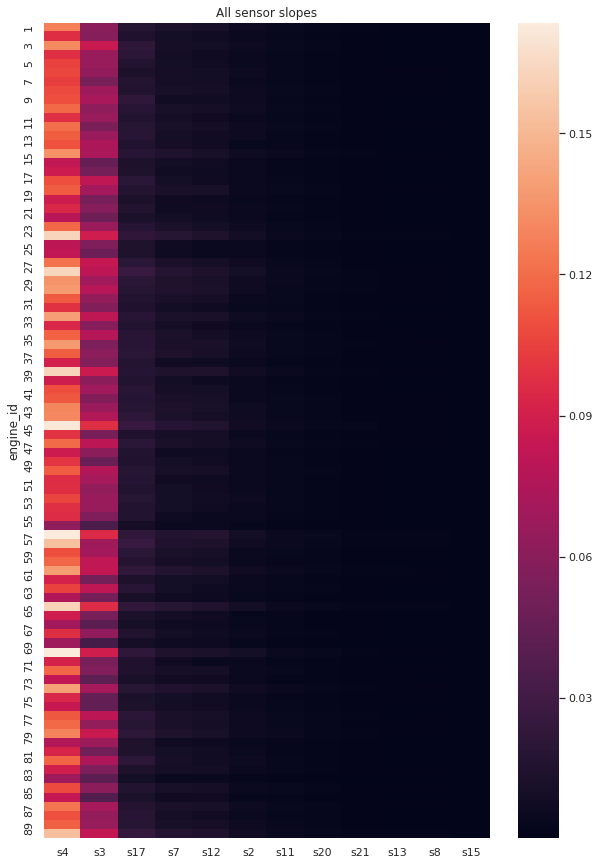

In [26]:
plt.figure(figsize=(10, 15))
sns.heatmap(df_engine_slopes[high_trend_sensors].abs(), cbar=True)
plt.title('All sensor slopes');

### PCA on the sensor slopes

In [27]:
from sklearn.decomposition import PCA

In [29]:
top_n_sensors = 6
n_components  = 3

high_trend = df_train_norm[high_trend_sensors[:top_n_sensors]]

pca = PCA(n_components=n_components)
pca.fit(high_trend);

#### Variance explained by the different pca components

In [35]:
var_explained = sum((100 * pca.explained_variance_ratio_).tolist())
round(var_explained, 2)

88.36

#### Only select top n sensors

In [36]:
sensors_pca = pca.transform(high_trend)
sensors_pca.shape

(18380, 3)

In [37]:
sensors_pca[:5]

array([[-2.06129736,  0.85877166, -0.49074592],
       [-1.61779125,  0.93130613, -0.13639162],
       [-2.47552475,  0.61613067,  1.08967917],
       [-2.75105078, -0.36364042, -0.05714553],
       [-1.66926047, -0.69411773, -0.41511569]])

#### Join the pca with the original dataframe

In [38]:
matrix = np.column_stack([df_train_norm[['cycle', 'rul']].values, sensors_pca])

df_pca = pd.DataFrame(matrix, index=df_train.index, columns=['cycle', 'rul', 'pca1', 'pca2', 'pca3'])
df_pca.head()

cycle    rul      pca1      pca2      pca3
engine_id                                            
1            1.0  192.0 -2.061297  0.858772 -0.490746
1            2.0  191.0 -1.617791  0.931306 -0.136392
1            3.0  190.0 -2.475525  0.616131  1.089679
1            4.0  189.0 -2.751051 -0.363640 -0.057146
1            5.0  188.0 -1.669260 -0.694118 -0.415116

### Sensor fusing

In [39]:
high_rul = 250
low_rul  = 5
ruls     = df_pca['rul'].values

In [40]:
idx_high_health = [ruls > high_rul][0]
idx_low_health  = [ruls <= low_rul][0]

In [41]:
# PCA to perform sensor fusing on
high_health_data = df_pca.loc[idx_high_health, ['pca1', 'pca2', 'pca3']]
low_health_data  = df_pca.loc[idx_low_health, ['pca1', 'pca2', 'pca3']]

# concatenate high HI and Low HI data
X_health = np.concatenate((high_health_data, low_health_data),axis=0)

# target for the fused signal [ just 0 or 1 for failed ans healthy]
y_one = np.ones(high_health_data.shape[0])
y_zero = np.zeros(low_health_data.shape[0])

# concatenate high HI and Low HI target
y_health = np.concatenate((y_one, y_zero),axis=0)

In [42]:
X_health[:5]

array([[-3.53441269,  0.28836692, -0.05628205],
       [-3.38003821,  0.70629002, -0.70699197],
       [-3.59648401,  1.20819255, -0.45264335],
       [-3.4127827 ,  0.41992825, -0.26132903],
       [-3.92414737, -0.18715612,  0.32544327]])

In [43]:
y_health[:5]

array([1., 1., 1., 1., 1.])

In [44]:
# Linear regression
linear_model = LinearRegression()
linear_model.fit(X_health, y_health)

# Logistic regression
logistic_model = LogisticRegression(solver='liblinear')
logistic_model.fit(X_health, y_health);

#### Predict the health index for a certain engine

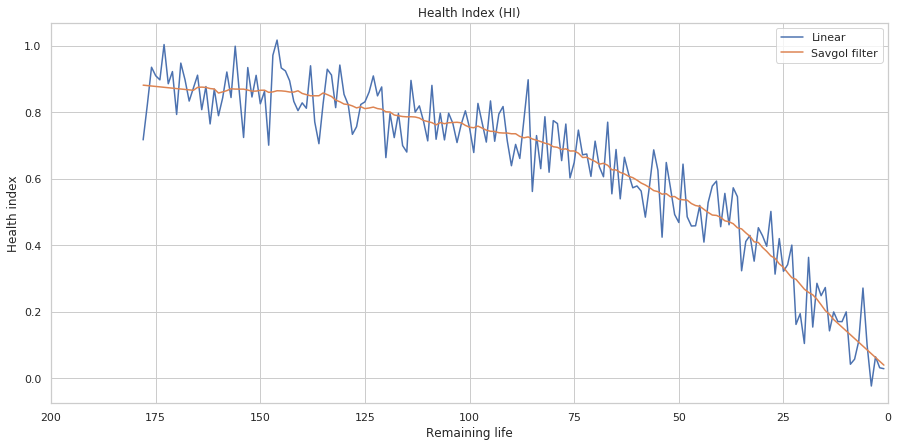

In [45]:
def health_index_of_engine(dataframe, engine_id, model):
    engine_sensors = dataframe.loc[engine_id, ['pca1', 'pca2', 'pca3']]
    engine_rul     = dataframe.loc[engine_id, 'rul']

    # Predict the health index
    health_pred = model.predict(engine_sensors)
    
    return (engine_rul, health_pred)

x, y = health_index_of_engine(df_pca, ENGINE_ID, linear_model)

# Plot the health index
fig = plt.figure(figsize=(15,7))
plt.plot(x, y, label='Linear')
plt.plot(x, savgol_filter(y, 25, 1), label='Savgol filter')
plt.title('Health Index (HI)')
plt.xlabel('Remaining life')
plt.ylabel('Health index')
plt.xlim(200, 0)
plt.legend();

#### Plot health indices for all engines

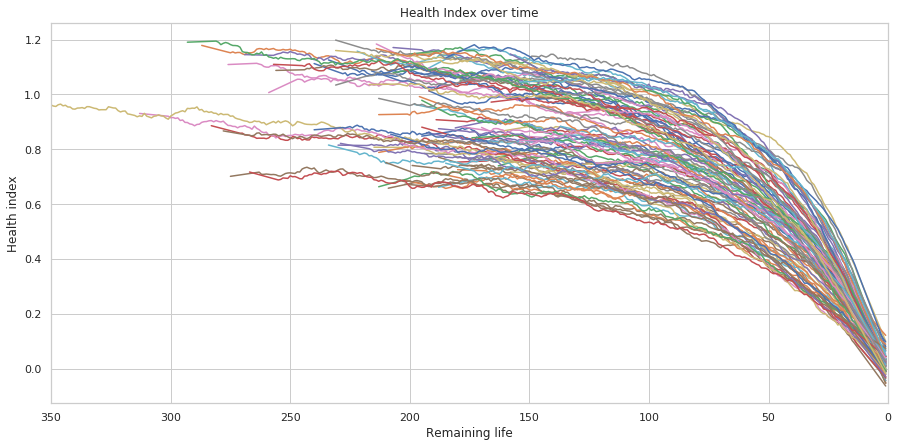

In [46]:
# Plot the health index
fig = plt.figure(figsize=(15,7))

for engine_id in df_pca.index.unique():
    x, y = health_index_of_engine(df_pca, engine_id, linear_model)

    plt.plot(x, savgol_filter(y, 25, 1), label='Savgol filter', linewidth=1.5)
    
plt.title('Health Index over time')
plt.xlabel('Remaining life')
plt.ylabel('Health index')
plt.xlim(350, 0);

### Fitting the health index curve

In [47]:
from scipy.optimize import curve_fit

In [48]:
df_health_index = df_pca.copy()

df_health_index['hi_pred'] = linear_model.predict(df_health_index[['pca1', 'pca2', 'pca3']])

df_health_index.head()

cycle    rul      pca1      pca2      pca3   hi_pred
engine_id                                                      
1            1.0  192.0 -2.061297  0.858772 -0.490746  0.986230
1            2.0  191.0 -1.617791  0.931306 -0.136392  0.925984
1            3.0  190.0 -2.475525  0.616131  1.089679  1.046315
1            4.0  189.0 -2.751051 -0.363640 -0.057146  1.090202
1            5.0  188.0 -1.669260 -0.694118 -0.415116  0.945858

In [49]:
def exp_func(x, a, b):
    return a * (np.exp(b * -x)-1)

x = df_health_index.loc[ENGINE_ID, 'rul']
y = savgol_filter(df_health_index.loc[ENGINE_ID, 'hi_pred'], 25, 1)

popt, _ = curve_fit(exp_func, x, y)
popt

array([-0.92014332,  0.01776918])

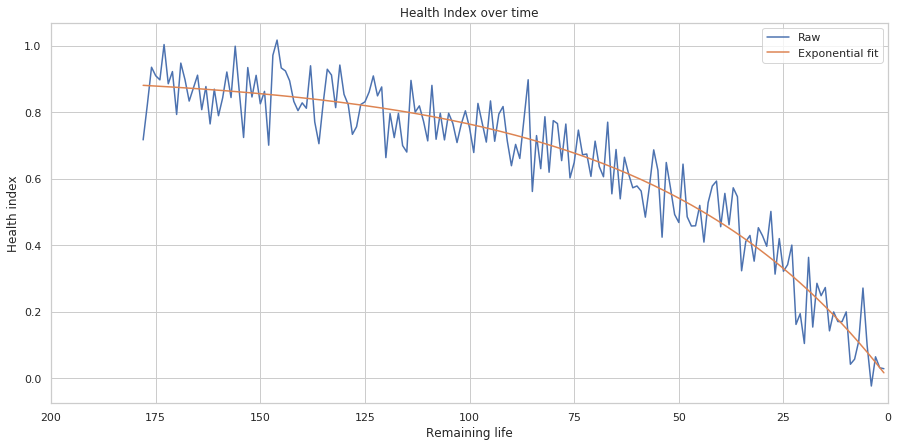

In [50]:
# Plot the health index
fig = plt.figure(figsize=(15,7))

x, y = health_index_of_engine(df_pca, ENGINE_ID, linear_model)

plt.plot(x, y, label='Raw')
plt.plot(x, exp_func(x, *popt), label='Exponential fit')
    
plt.title('Health Index over time')
plt.xlabel('Remaining life')
plt.ylabel('Health index')
plt.xlim(200, 0)
plt.legend();

In [51]:
def find_exp_params(dataframe):
    exp_params = np.zeros((dataframe.index.nunique(), 2))
    
    # Loop through the engines
    for idx, (engine_id, engine) in enumerate(dataframe.groupby('engine_id')):
        x = engine['rul']
        y = savgol_filter(engine['hi_pred'], 25, 1)

        popt, _ = curve_fit(exp_func, x, y)
        
        exp_params[idx, :] = popt
        
    return exp_params
        
exp_params = find_exp_params(df_health_index)
exp_params[:5]

array([[-1.03913244,  0.01885149],
       [-1.20410417,  0.01264254],
       [-1.05088079,  0.02661706],
       [-0.90931573,  0.02659976],
       [-1.18615481,  0.01377137]])

#### Add the exponential fits to the dataframe

In [52]:
def get_exponential(timestep):
    return exp_func(timestep['rul'], *exp_params[timestep.name-1, :])

df_health_index['exp'] = df_health_index.apply(get_exponential, axis=1)
df_health_index.head()

cycle    rul      pca1      pca2      pca3   hi_pred       exp
engine_id                                                                
1            1.0  192.0 -2.061297  0.858772 -0.490746  0.986230  1.011287
1            2.0  191.0 -1.617791  0.931306 -0.136392  0.925984  1.010758
1            3.0  190.0 -2.475525  0.616131  1.089679  1.046315  1.010218
1            4.0  189.0 -2.751051 -0.363640 -0.057146  1.090202  1.009667
1            5.0  188.0 -1.669260 -0.694118 -0.415116  0.945858  1.009107

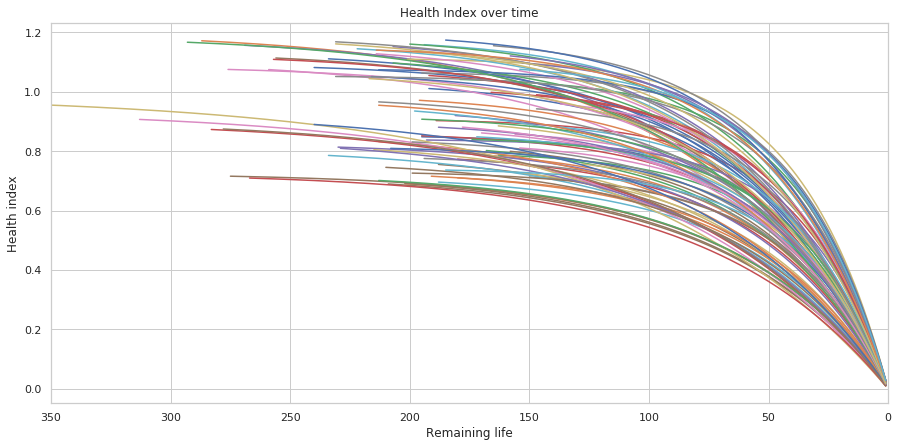

In [53]:
# Plot the health index
fig = plt.figure(figsize=(15,7))

for engine_id, engine in df_health_index.groupby('engine_id'):
    x = engine['rul']
    y = engine['exp']

    plt.plot(x, y, linewidth=1.5)
    
plt.title('Health Index over time')
plt.xlabel('Remaining life')
plt.ylabel('Health index')
plt.xlim(350, 0);

### Make a prediction
#### Normalize the test sensors

In [65]:
df_test_norm = df_test.copy()

df_test_norm.iloc[:, 1:-1] = scaler.fit_transform(df_test.iloc[:, 1:-1])

df_test_norm.head()

cycle       s11        s4       s12        s7       s15       s21  \
engine_id                                                                      
91             1  0.609975  0.273986 -0.007315  1.305661 -0.144597 -0.094766   
91             2  0.345810 -0.341493 -0.399023 -0.874924 -1.000608  0.234099   
91             3 -0.144782  0.109858 -0.049284 -0.291879 -0.117763 -0.306722   
91             4 -0.182520  0.139800 -0.203169 -0.175271  0.499424  0.420392   
91             5 -0.144782 -0.207308  0.006675 -0.198592  0.936821  0.267366   

                s20       s17        s2        s3       s13        s8  rul  
engine_id                                                                   
91        -0.297044 -0.105592  1.516114 -0.397957  0.286284 -0.165254  135  
91        -0.964024 -0.105592  0.172084 -0.924778 -0.017118  0.899740  134  
91         1.203659 -0.758582 -0.088698  0.447218  1.348192  0.595456  133  
91         0.592262 -0.105592  1.255332  0.736485  0.286284  0.443314  132  
91         1.092496 -0.758582  0.753828  0.561955  0.893089  0.899740  131

#### Perform PCA dimensionality reduction on the test sensors

In [90]:
# The sensors used for pca transformation
pca_sensors = ['s4', 's3', 's17', 's7', 's12', 's2']

# Transform the sensors with pca
pca_transformation = pd.DataFrame(pca.transform(df_test_norm[pca_sensors]), index=df_test_norm.index)

# Join the cycle, rul and pca data
df_test_pca = pd.concat([df_test_norm[['cycle', 'rul']], pca_transformation], axis=1)

df_test_pca.columns = ['cycle', 'rul', 'pca1', 'pca2', 'pca3']

df_test_pca.head()

cycle  rul      pca1      pca2      pca3
engine_id                                          
91             1  135 -0.025780 -0.723677  0.874985
91             2  134  0.071444 -0.962088  0.242801
91             3  133  0.030135  0.571708  0.602898
91             4  132  0.956131  0.220910  0.839515
91             5  131  0.207754  0.432338  1.048481

#### Health indicator prediction

In [91]:
df_test_pca['hi_pred'] = linear_model.predict(df_test_pca[['pca1', 'pca2', 'pca3']])

df_test_pca.head()

cycle  rul      pca1      pca2      pca3   hi_pred
engine_id                                                    
91             1  135 -0.025780 -0.723677  0.874985  0.725009
91             2  134  0.071444 -0.962088  0.242801  0.712988
91             3  133  0.030135  0.571708  0.602898  0.706534
91             4  132  0.956131  0.220910  0.839515  0.584210
91             5  131  0.207754  0.432338  1.048481  0.684158

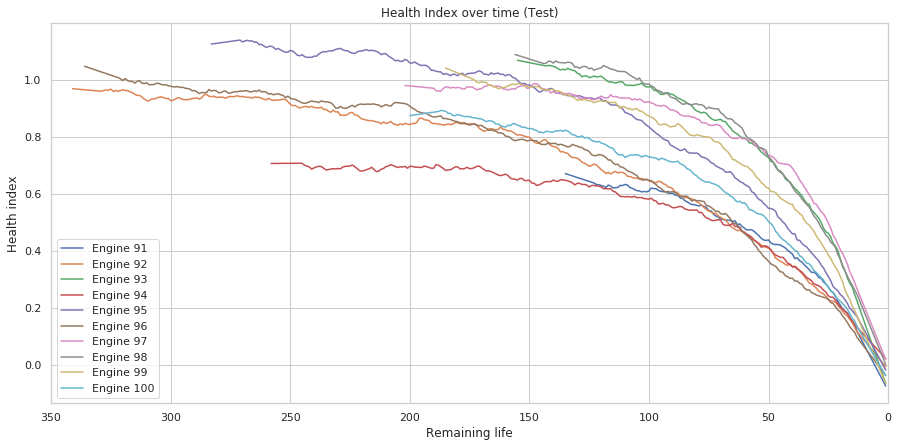

In [96]:
# Plot the health index
fig = plt.figure(figsize=(15,7))

for engine_id in df_test_pca.index.unique():
    x, y = health_index_of_engine(df_test_pca, engine_id, linear_model)

    plt.plot(x, savgol_filter(y, 25, 1), label=f'Engine {engine_id}', linewidth=1.5)
    
plt.title('Health Index over time (Test)')
plt.xlabel('Remaining life')
plt.ylabel('Health index')
plt.legend()
plt.xlim(350, 0);

### Prediction test

In [190]:
test = df_test_pca.iloc[290:450]
test

cycle  rul      pca1      pca2      pca3   hi_pred
engine_id                                                    
92           156  186 -0.963141  0.041604 -0.297029  0.844325
92           157  185 -1.602928  0.756176 -0.175435  0.925348
92           158  184 -2.228098 -0.202563 -0.641114  1.017296
92           159  183 -0.829370  0.312652  1.006910  0.825619
92           160  182 -0.461767 -0.115715 -0.357104  0.777593
...          ...  ...       ...       ...       ...       ...
92           311   31  3.177087 -0.297105 -0.688006  0.285568
92           312   30  3.483496  0.542612 -0.528213  0.237402
92           313   29  3.058222  0.811596 -0.252207  0.293183
92           314   28  3.304651  0.191108 -0.783489  0.264183
92           315   27  2.319188  0.127631 -0.519365  0.398568

[160 rows x 6 columns]

In [194]:
length = len(test)

best_loss = np.inf

for i in range(0, len(df_health_index)-length):    
    train_slice = df_health_index.iloc[i:i+length]
    train_health_index = train_slice['exp'].values
#     test_health_index = savgol_filter(test['hi_pred'].values, 25, 1)
    test_health_index = test['hi_pred'].values

    loss = np.sum((train_health_index - test_health_index) ** 2)
    
    if loss < best_loss:
        best_loss        = loss
        best_train_slice = train_slice
        
        print('Best loss:', best_loss)
        print('Train RUL:', int(train_slice.iloc[-1]['rul']))
        print('Test RUL:', int(test.iloc[-1]['rul']))
        print('---------------------------------------------')

Best loss: 9.711076273541456
Train RUL: 33
Test RUL: 27
---------------------------------------------
Best loss: 9.441967668187303
Train RUL: 32
Test RUL: 27
---------------------------------------------
Best loss: 9.173988950446091
Train RUL: 31
Test RUL: 27
---------------------------------------------
Best loss: 8.907401807225266
Train RUL: 30
Test RUL: 27
---------------------------------------------
Best loss: 8.642482133978197
Train RUL: 29
Test RUL: 27
---------------------------------------------
Best loss: 8.379520659684085
Train RUL: 28
Test RUL: 27
---------------------------------------------
Best loss: 8.118823597345664
Train RUL: 27
Test RUL: 27
---------------------------------------------
Best loss: 7.860713321013741
Train RUL: 26
Test RUL: 27
---------------------------------------------
Best loss: 7.605529070387012
Train RUL: 25
Test RUL: 27
---------------------------------------------
Best loss: 7.35362768407639
Train RUL: 24
Test RUL: 27
---------------------------

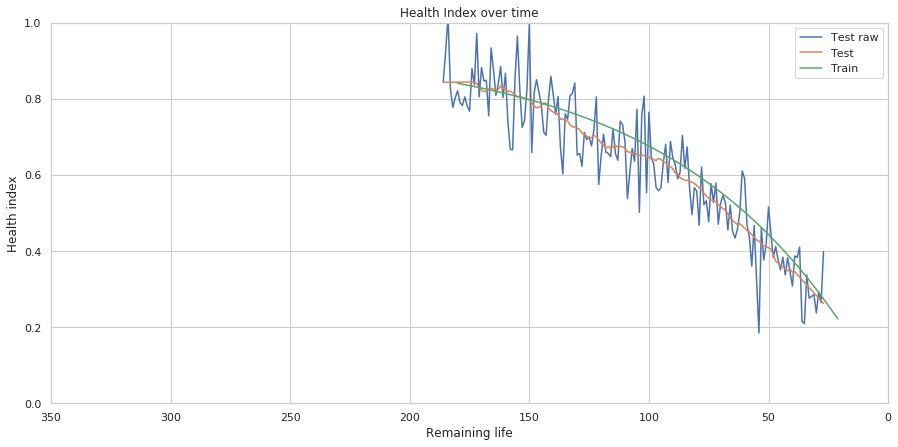

In [197]:
fig = plt.figure(figsize=(15,7))
plt.plot(test['rul'], test['hi_pred'], label='Test raw')
plt.plot(test['rul'], savgol_filter(test['hi_pred'], 25, 1), label='Test')
plt.plot(best_train_slice['rul'], best_train_slice['exp'], label='Train')

plt.title('Health Index over time')
plt.xlabel('Remaining life')
plt.ylabel('Health index')
plt.ylim(0, 1)
plt.xlim(350, 0)
plt.legend();

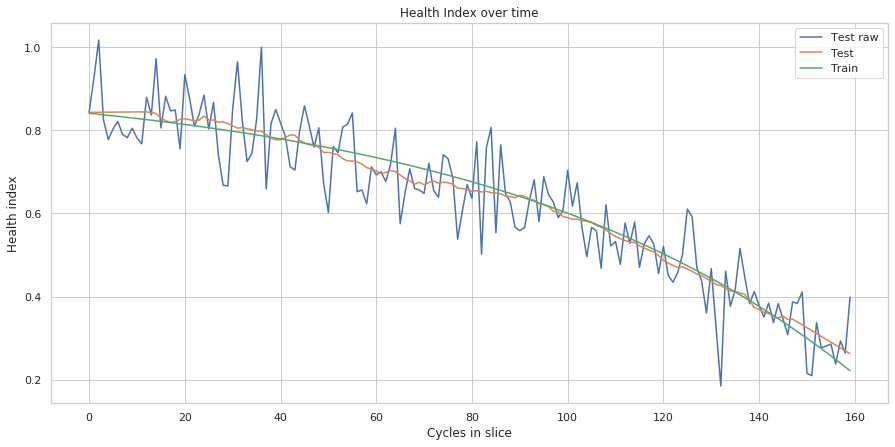

In [198]:
fig = plt.figure(figsize=(15,7))
plt.plot(np.arange(len(test)), test['hi_pred'], label='Test raw')
plt.plot(np.arange(len(test)), savgol_filter(test['hi_pred'], 25, 1), label='Test')
plt.plot(np.arange(len(test)), best_train_slice['exp'], label='Train')

plt.title('Health Index over time')
plt.xlabel('Cycles in slice')
plt.ylabel('Health index')
plt.legend();

In [167]:
df_schedule

cycle  setting1  setting2  setting3      s1      s2       s3  \
engine_id                                                                 
1              1    0.0023    0.0003     100.0  518.67  643.02  1585.29   
1              2   -0.0027   -0.0003     100.0  518.67  641.71  1588.45   
1              3    0.0003    0.0001     100.0  518.67  642.46  1586.94   
1              4    0.0042    0.0000     100.0  518.67  642.44  1584.12   
1              5    0.0014    0.0000     100.0  518.67  642.51  1587.19   
...          ...       ...       ...       ...     ...     ...      ...   
100          194    0.0049    0.0000     100.0  518.67  643.24  1599.45   
100          195   -0.0011   -0.0001     100.0  518.67  643.22  1595.69   
100          196   -0.0006   -0.0003     100.0  518.67  643.44  1593.15   
100          197   -0.0038    0.0001     100.0  518.67  643.26  1594.99   
100          198    0.0013    0.0003     100.0  518.67  642.95  1601.62   

                s4     s5     s6  ...     s12      s13      s14     s15   s16  \
engine_id                         ...                                           
1          1398.21  14.62  21.61  ...  521.72  2388.03  8125.55  8.4052  0.03   
1          1395.42  14.62  21.61  ...  522.16  2388.06  8139.62  8.3803  0.03   
1          1401.34  14.62  21.61  ...  521.97  2388.03  8130.10  8.4441  0.03   
1          1406.42  14.62  21.61  ...  521.38  2388.05  8132.90  8.3917  0.03   
1          1401.92  14.62  21.61  ...  522.15  2388.03  8129.54  8.4031  0.03   
...            ...    ...    ...  ...     ...      ...      ...     ...   ...   
100        1415.79  14.62  21.61  ...  520.69  2388.00  8213.28  8.4715  0.03   
100        1422.05  14.62  21.61  ...  521.05  2388.09  8210.85  8.4512  0.03   
100        1406.82  14.62  21.61  ...  521.18  2388.04  8217.24  8.4569  0.03   
100        1419.36  14.62  21.61  ...  521.33  2388.08  8220.48  8.4711  0.03   
100        1424.99  14.62  21.61  ...  521.07  2388.05  8214.64  8.4903  0.03   

           s17   s18    s19    s20      s21  
engine_id                                    
1          392  2388  100.0  38.86  23.3735  
1          393  2388  100.0  39.02  23.3916  
1          393  2388  100.0  39.08  23.4166  
1          391  2388  100.0  39.00  23.3737  
1          390  2388  100.0  38.99  23.4130  
...        ...   ...    ...    ...      ...  
100        394  2388  100.0  38.65  23.1974  
100        395  2388  100.0  38.57  23.2771  
100        395  2388  100.0  38.62  23.2051  
100        395  2388  100.0  38.66  23.2699  
100        396  2388  100.0  38.70  23.1855  

[13096 rows x 25 columns]

In [ ]:
def plot_timeseries(dataframe):
    ts = dataframe.copy()
    
    max_rul = ts['rul'].max()
    
    ts.drop(labels=['cycle'], axis=1, inplace=True)

    cols = ts.columns
    fig, axes = plt.subplots(len(cols)-1, 1, figsize=(18,25), sharex=True)

    for col, ax in zip(cols, axes):
        if col == 'rul':
            continue

        ax.set_title(col, fontdict={'fontsize': 12})
        ax.set_xlim(max_rul, 1)
        ax.get_yaxis().set_visible(False)

        for engine_id in ts.index.unique():
            time = ts.loc[engine_id, 'rul']
            ax.plot(time, ts.loc[engine_id,col], label=col, linewidth=1)

    plt.subplots_adjust(hspace=0.3)
    
plot_timeseries(df_train)

In [168]:
cols = df_schedule.iloc[:, 1:].columns
cols

Index(['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6',
       's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16',
       's17', 's18', 's19', 's20', 's21'],
      dtype='object')

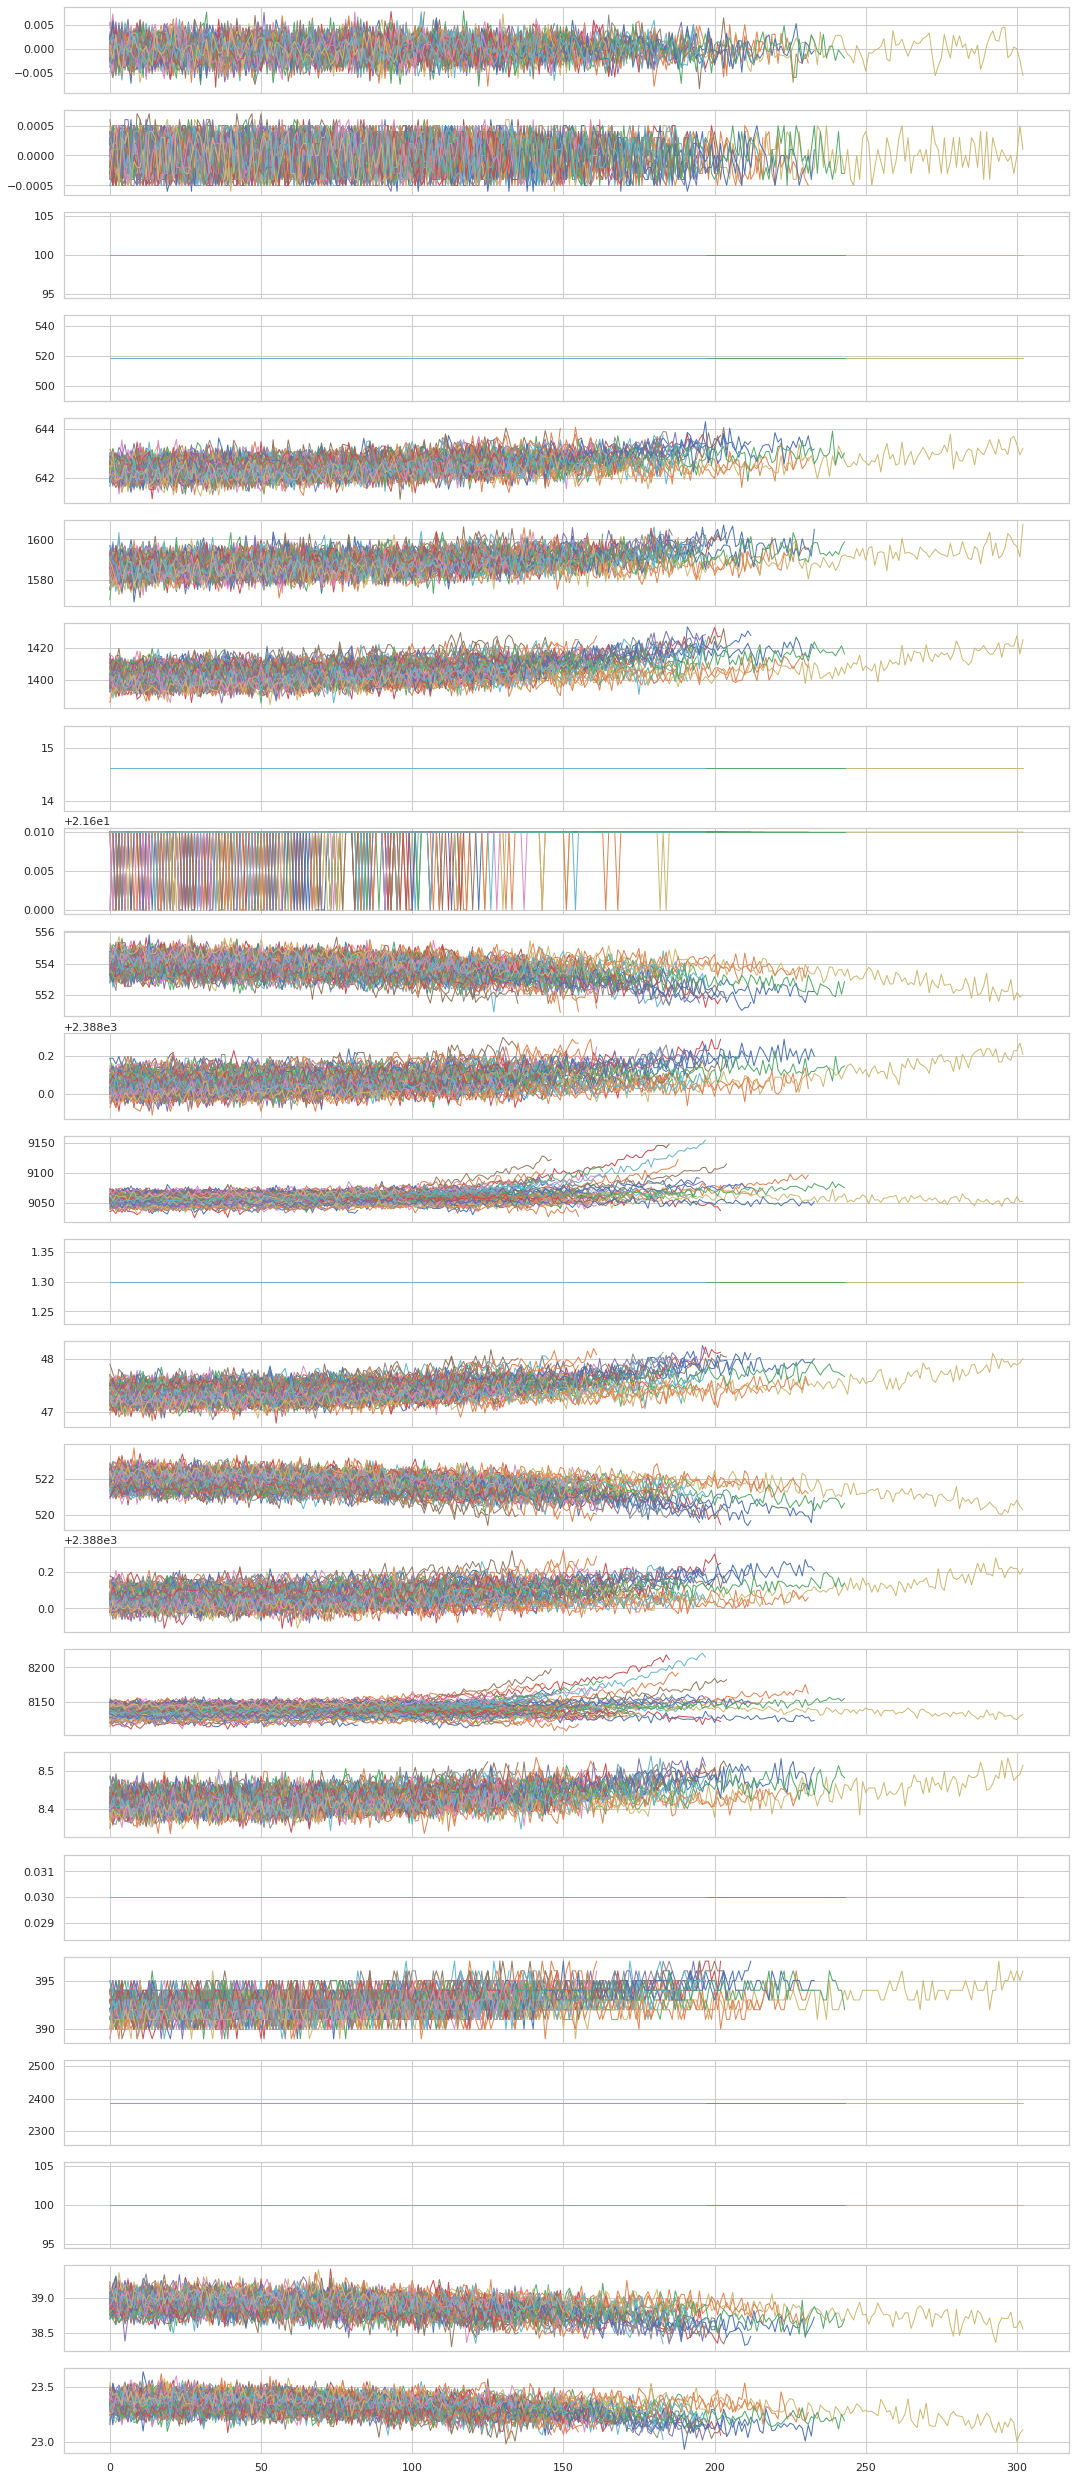

In [171]:
fig, axes = plt.subplots(len(cols), 1, figsize=(18,45), sharex=True)

for col, ax in zip(cols, axes):
    
    for engine_id, engine in df_schedule.groupby('engine_id'):
#         print(engine_id)
    
        ax.plot(np.arange(len(engine)), engine[col], label=col, linewidth=1)

In [166]:
df_schedule = load_dataset('../data/DataSchedule.txt')
df_schedule = df_schedule.set_index('engine_id')

 

unique_engine_ids = df_schedule.index.unique()
amount_of_ruls    = {engine_id : df_schedule[df_schedule.index == engine_id]['cycle'].max() for engine_id in unique_engine_ids}

 

amount_of_ruls

{1: 31,
 2: 49,
 3: 126,
 4: 106,
 5: 98,
 6: 105,
 7: 160,
 8: 166,
 9: 55,
 10: 192,
 11: 83,
 12: 217,
 13: 195,
 14: 46,
 15: 76,
 16: 113,
 17: 165,
 18: 133,
 19: 135,
 20: 184,
 21: 148,
 22: 39,
 23: 130,
 24: 186,
 25: 48,
 26: 76,
 27: 140,
 28: 158,
 29: 171,
 30: 143,
 31: 196,
 32: 145,
 33: 50,
 34: 203,
 35: 198,
 36: 126,
 37: 121,
 38: 125,
 39: 37,
 40: 133,
 41: 123,
 42: 156,
 43: 172,
 44: 54,
 45: 152,
 46: 146,
 47: 73,
 48: 78,
 49: 303,
 50: 74,
 51: 144,
 52: 189,
 53: 164,
 54: 121,
 55: 113,
 56: 136,
 57: 160,
 58: 176,
 59: 94,
 60: 147,
 61: 159,
 62: 232,
 63: 155,
 64: 168,
 65: 71,
 66: 147,
 67: 71,
 68: 187,
 69: 54,
 70: 152,
 71: 68,
 72: 131,
 73: 112,
 74: 137,
 75: 88,
 76: 205,
 77: 162,
 78: 72,
 79: 101,
 80: 133,
 81: 213,
 82: 162,
 83: 73,
 84: 172,
 85: 34,
 86: 110,
 87: 56,
 88: 68,
 89: 177,
 90: 146,
 91: 234,
 92: 150,
 93: 244,
 94: 133,
 95: 89,
 96: 97,
 97: 134,
 98: 121,
 99: 97,
 100: 198}

In [112]:
from random import randint

In [116]:
def extract_part_test_data(dataframe_test):
    unique_engine_ids = dataframe_test.index.unique()
    amount_of_ruls    = {engine_id : dataframe_test[dataframe_test.index == engine_id]['cycle'].max() for engine_id in unique_engine_ids}
    
    display(amount_of_ruls)
    
    new_df = pd.DataFrame()
    
    for engine_id, max_length in amount_of_ruls.items():
        random_numbers = np.random.randint(0, max_length - 1, 2)
        random_numbers_sorted = np.sort(random_numbers, axis=None)
        print('Engine Id filtered on index : {}.'.format(random_numbers_sorted))
        
        df_filtered = dataframe_test[dataframe_test.index == engine_id]
        df_filtered = df_filtered.iloc[random_numbers_sorted[0] : random_numbers_sorted[1]]
        
        new_df = new_df.append(df_filtered)
        
    return new_df

test = extract_part_test_data(df_test_pca)

{91: 135,
 92: 341,
 93: 155,
 94: 258,
 95: 283,
 96: 336,
 97: 202,
 98: 156,
 99: 185,
 100: 200}

Engine Id filtered on index : [  7 108].
Engine Id filtered on index : [196 281].
Engine Id filtered on index : [ 2 59].
Engine Id filtered on index : [ 87 149].
Engine Id filtered on index : [219 281].
Engine Id filtered on index : [124 246].
Engine Id filtered on index : [148 151].
Engine Id filtered on index : [ 1 56].
Engine Id filtered on index : [ 19 114].
Engine Id filtered on index : [80 86].


In [117]:
test

cycle  rul      pca1      pca2      pca3   hi_pred
engine_id                                                    
91             8  128  0.122108 -1.349667  0.921549  0.710130
91             9  127  0.692038 -0.186064  0.838207  0.623312
91            10  126  1.265969 -0.511658 -0.732674  0.546230
91            11  125  1.245610 -0.490716  0.698981  0.550608
91            12  124  0.369770 -0.784673 -0.230988  0.670524
...          ...  ...       ...       ...       ...       ...
100           82  119 -0.563481 -0.337449  0.008757  0.793641
100           83  118  0.192149  0.597407 -0.914302  0.682473
100           84  117 -0.520624  1.003062  0.154761  0.777089
100           85  116 -0.224055  0.442960 -0.937253  0.740102
100           86  115  0.640611  0.102137  0.164868  0.627090

[648 rows x 6 columns]